<a href="https://colab.research.google.com/github/JaviCeRodriguez/Intro_Ciencia_Datos/blob/main/Final_ICD/pacientes_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análisis del dataset para la implementación de modelos predictivos ##

<a id='Volver_indice'></a>

In [1]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ***Importación de librerías***

In [2]:
#importación de librerías básicas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime

# importación de librerias para análisis de modelos y métricas
%matplotlib inline
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFECV, RFE, chi2
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

sns.set()
sns.set_context("talk")

[Volver al índice](#Volver_indice)
<a href='#Volver_indice'></a> 

# Análisis descriptivo del dataset ###

In [3]:
!wget https://raw.githubusercontent.com/JaviCeRodriguez/Intro_Ciencia_Datos/main/Final_ICD/para_ejercitacion_con_RCVG_1.csv

--2022-11-25 12:17:40--  https://raw.githubusercontent.com/JaviCeRodriguez/Intro_Ciencia_Datos/main/Final_ICD/para_ejercitacion_con_RCVG_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14722510 (14M) [text/plain]
Saving to: ‘para_ejercitacion_con_RCVG_1.csv.1’

para_ejercitacion_c 100%[===================>]  14.04M  24.9MB/s    in 0.6s    

2022-11-25 12:17:40 (24.9 MB/s) - ‘para_ejercitacion_con_RCVG_1.csv.1’ saved [14722510/14722510]



In [4]:
%%time
data = pd.read_csv('para_ejercitacion_con_RCVG_1.csv',sep=';',encoding='utf_8')

data = data.drop_duplicates()
now = datetime.datetime.now()
data['EDAD']= (now - pd.to_datetime(data['FECHA DE NACIMIENTO'])).astype('<m8[Y]') 
data.rename(columns={'ENF. CARDIOVASCULAR ESTABLECIDA':'ENF.CARDIOVASCULAR_ESTABLECIDA'},inplace=True)

# df va a ser el dataset que se va a utilizar para predecir
df = data[['TAS','TAD','SEXO', 'DIABETES', 'DISLIPEMIA', 'OBESIDAD','UTMO_IMC', 'CLASIFICACION_IMC', 'CLEARANCE','COLESTEROL_TOTAL','EDAD','HIPERTENSION']]
df = df.dropna()

df = pd.get_dummies(df, prefix=['SEXO', 'DIABETES', 'DISLIPEMIA', 'OBESIDAD','CLASIFICACION_IMC','HIPERTENSION'], columns=['SEXO', 'DIABETES', 'DISLIPEMIA', 'OBESIDAD','CLASIFICACION_IMC','HIPERTENSION'],drop_first = True)

#print(data.columns)
print('Columnas iniciales que se consideran para predecir hipertensión:\n', df.columns)
print('\nDimensiones del dataset a analizar:',  df.shape)
hta_counts = df.HIPERTENSION_SI.value_counts(normalize=True)
print('\nPorcentaje de no hipertensos:', round(hta_counts[0],3))
print('\nPorcentaje de hipertensos:', round(hta_counts[1],3))

Columnas iniciales que se consideran para predecir hipertensión:
 Index(['TAS', 'TAD', 'UTMO_IMC', 'CLEARANCE', 'COLESTEROL_TOTAL', 'EDAD',
       'SEXO_MASCULINO', 'DIABETES_DM2', 'DIABETES_NO', 'DISLIPEMIA_SI',
       'OBESIDAD_SI', 'CLASIFICACION_IMC_NORMAL', 'CLASIFICACION_IMC_OBESIDAD',
       'CLASIFICACION_IMC_SOBREPESO', 'HIPERTENSION_SI'],
      dtype='object')

Dimensiones del dataset a analizar: (11995, 15)

Porcentaje de no hipertensos: 0.632

Porcentaje de hipertensos: 0.368
CPU times: user 782 ms, sys: 110 ms, total: 892 ms
Wall time: 948 ms


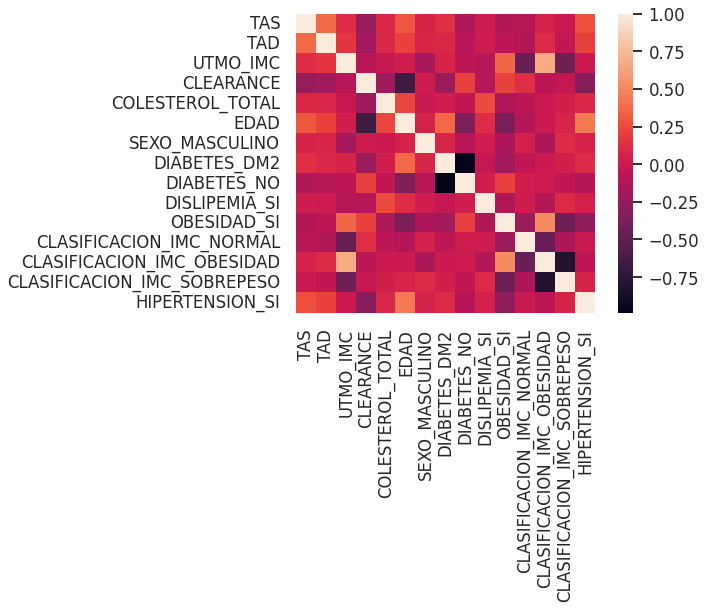

In [5]:
sns.heatmap(df.corr(),square=True);

In [6]:
display(df.corr())

,TAS,TAD,UTMO_IMC,CLEARANCE,COLESTEROL_TOTAL,EDAD,SEXO_MASCULINO,DIABETES_DM2,DIABETES_NO,DISLIPEMIA_SI,OBESIDAD_SI,CLASIFICACION_IMC_NORMAL,CLASIFICACION_IMC_OBESIDAD,CLASIFICACION_IMC_SOBREPESO,HIPERTENSION_SI
TAS,1.000000,0.373259,0.117725,-0.236026,0.092405,0.298763,0.072046,0.135030,-0.130956,0.020998,-0.112089,-0.093509,0.068126,-0.004601,0.267921
TAD,0.373259,1.000000,0.165450,-0.181286,0.087609,0.223983,0.081750,0.094201,-0.090545,0.009635,-0.062504,-0.113101,0.109476,-0.036829,0.212572
UTMO_IMC,0.117725,0.165450,1.000000,-0.089854,-0.012893,0.036609,-0.157508,0.070989,-0.055384,-0.093338,0.361515,-0.443536,0.667073,-0.428110,0.004170
CLEARANCE,-0.236026,-0.181286,-0.089854,1.000000,-0.206291,-0.658735,0.020981,-0.216122,0.212669,-0.089430,0.223248,0.132182,-0.074972,-0.022722,-0.308472
COLESTEROL_TOTAL,0.092405,0.087609,-0.012893,-0.206291,1.000000,0.238339,-0.007817,0.034578,-0.034201,0.248065,-0.129990,-0.056025,-0.000586,0.043095,0.094701
EDAD,0.298763,0.223983,0.036609,-0.658735,0.238339,1.000000,0.067757,0.366102,-0.354728,0.118177,-0.361318,-0.104222,0.006317,0.079803,0.445214
SEXO_MASCULINO,0.072046,0.081750,-0.157508,0.020981,-0.007817,0.067757,1.000000,0.081929,-0.088255,0.030412,-0.137550,0.055249,-0.140136,0.115071,0.063704
DIABETES_DM2,0.135030,0.094201,0.070989,-0.216122,0.034578,0.366102,0.081929,1.000000,-0.986277,-0.029613,-0.194214,-0.054926,0.000291,0.041399,0.108233
DIABETES_NO,-0.130956,-0.090545,-0.055384,0.212669,-0.034201,-0.354728,-0.088255,-0.986277,1.000000,0.031482,0.208401,0.030959,0.013983,-0.038946,-0.100470
DISLIPEMIA_SI,0.020998,0.009635,-0.093338,-0.089430,0.248065,0.118177,0.030412,-0.029613,0.031482,1.000000,-0.131752,0.015402,-0.101413,0.103722,0.050048


In [7]:
df.describe()
# se observan outliers

,TAS,TAD,UTMO_IMC,CLEARANCE,COLESTEROL_TOTAL,EDAD,SEXO_MASCULINO,DIABETES_DM2,DIABETES_NO,DISLIPEMIA_SI,OBESIDAD_SI,CLASIFICACION_IMC_NORMAL,CLASIFICACION_IMC_OBESIDAD,CLASIFICACION_IMC_SOBREPESO,HIPERTENSION_SI
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,125.016924,77.296207,33.876969,97.810954,183.751582,49.376407,0.312547,0.315882,0.678116,0.120550,0.739808,0.070279,0.729554,0.194164,0.368404
std,29.247829,18.169841,6.931371,31.151028,43.530877,18.602531,0.463551,0.464885,0.467218,0.325617,0.438757,0.255628,0.444209,0.395572,0.482392
min,11.000000,7.000000,4.030000,0.160000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.000000,70.000000,29.590000,78.270000,154.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,120.000000,80.000000,33.080000,95.990000,180.000000,52.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,140.000000,83.000000,37.640000,113.545000,210.000000,63.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1580.000000,802.000000,78.490000,299.960000,593.000000,101.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# restriccion general en cuando a la edad del grupo etario a considerar en df
indexNames1=df[df.EDAD < 30].index
df.drop(indexNames1, inplace=True)
indexNames2=df[df.EDAD >78].index
df.drop(indexNames2, inplace=True)
print ('Cantidad de registros de df filtrado por edad:', df.shape[0])
df.EDAD

Cantidad de registros de df filtrado por edad: 9454


975      76.0
1184     76.0
1320     77.0
1390     77.0
1452     74.0
         ... 
59739    70.0
59788    44.0
59798    44.0
59876    43.0
59964    59.0
Name: EDAD, Length: 9454, dtype: float64

### Eliminacion de outliers ###

In [9]:
def rango_extremos(frame, label, quant_list):
    for i,v in enumerate(quant_list):
        if v > 0 and v < 100:
            quant_list[i] = v/100

    rango_outlier = frame[label].quantile(quant_list)
    return round(rango_outlier,2)

In [10]:
#Filtro valores_extremos en df segun percentiles
for v in ['COLESTEROL_TOTAL','CLEARANCE','UTMO_IMC','TAS','TAD']:
    rango_outlier = rango_extremos(df, v, [0.8, 99.8])
    rango_outlier=list(rango_outlier)
    mascara_outlier= (df[v]>= rango_outlier[0]) & (df[v] <= rango_outlier[1])
    df = df.drop(df[mascara_outlier == False].index)
    #print ('Cantidad de elementos iniciales: {}'.format(df.shape[0]))
    #print ('Cantidad de outliers encontrados: {}'.format(mascara_outlier_COL[mascara_outlier_COL == False].count()))
    #print ('Porcentaje de reduccion de registros de la categoría: {}%'.format(round(mascara_outlier_COL[mascara_outlier_COL == False].count()/df.shape[0]*100 ,2)))

print(df.shape[0])

9043


In [11]:
# dataset df sin outliers
df.describe()

,TAS,TAD,UTMO_IMC,CLEARANCE,COLESTEROL_TOTAL,EDAD,SEXO_MASCULINO,DIABETES_DM2,DIABETES_NO,DISLIPEMIA_SI,OBESIDAD_SI,CLASIFICACION_IMC_NORMAL,CLASIFICACION_IMC_OBESIDAD,CLASIFICACION_IMC_SOBREPESO,HIPERTENSION_SI
count,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000
mean,127.582550,79.192856,34.678948,91.864643,190.112108,54.095765,0.300675,0.367356,0.628663,0.141657,0.719341,0.039146,0.775296,0.185337,0.417671
std,18.804466,11.766933,6.506185,22.280333,41.329758,12.415639,0.458577,0.482111,0.483189,0.348717,0.449346,0.193954,0.417410,0.388592,0.493203
min,90.000000,55.000000,21.160000,15.330000,100.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,118.000000,70.000000,30.320000,77.000000,161.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,125.000000,80.000000,33.690000,92.920000,186.000000,55.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,140.000000,90.000000,38.270000,106.300000,215.000000,64.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,200.000000,120.000000,63.150000,167.970000,380.000000,78.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
df_data = df[['TAD','TAS','UTMO_IMC','CLEARANCE','COLESTEROL_TOTAL','EDAD']]
df_data

,TAD,TAS,UTMO_IMC,CLEARANCE,COLESTEROL_TOTAL,EDAD
975,70.0,110.0,36.41,18.52,125.0,76.0
1184,60.0,130.0,40.46,76.34,131.0,76.0
1320,90.0,150.0,30.40,60.20,225.0,77.0
1390,80.0,155.0,30.70,59.73,165.0,77.0
1452,60.0,130.0,30.04,61.69,109.0,74.0
...,...,...,...,...,...,...
59737,100.0,150.0,40.40,119.75,182.0,35.0
59739,83.0,137.0,23.20,77.15,191.0,70.0
59788,60.0,110.0,47.66,114.15,165.0,44.0
59876,80.0,155.0,41.04,70.88,261.0,43.0


Correlación de las variables con TAS

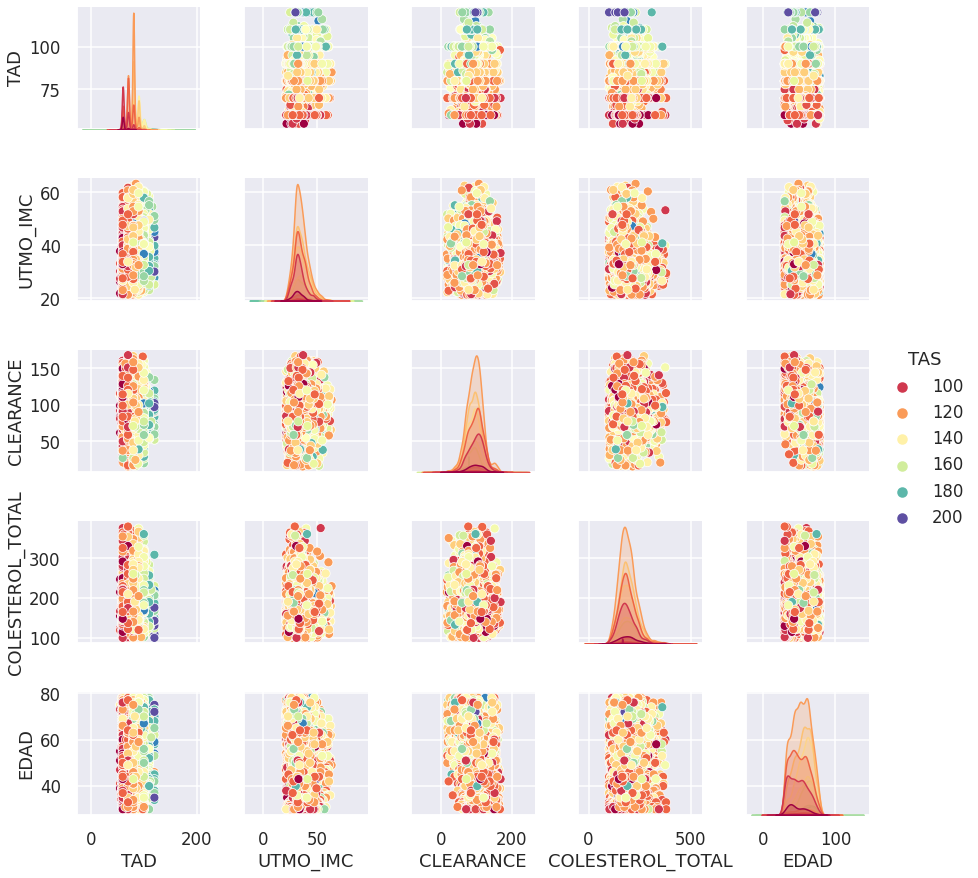

In [13]:
g=sns.pairplot(df_data, hue="TAS", palette="Spectral" )

In [14]:
# como quedaron las clases a predecir en df
print(df.shape)
df.HIPERTENSION_SI.value_counts(normalize=True)

(9043, 15)


0    0.582329
1    0.417671
Name: HIPERTENSION_SI, dtype: float64

<font color='pink'>* Notamos que las clases estan algo desbalanceadas. 

# Implementación del modelo Regresión lineal ###

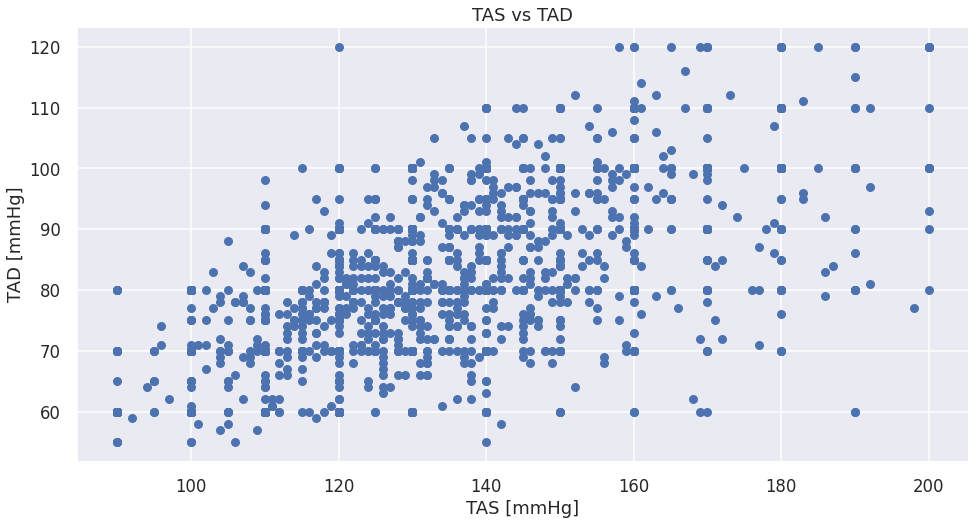

In [15]:
df_data.plot(x='TAS', y='TAD', style='o', figsize=(16, 8), legend=None)  
plt.title("TAS vs TAD")
plt.xlabel("TAS [mmHg]")
plt.ylabel("TAD [mmHg]")
plt.show()

<Figure size 1080x720 with 0 Axes>

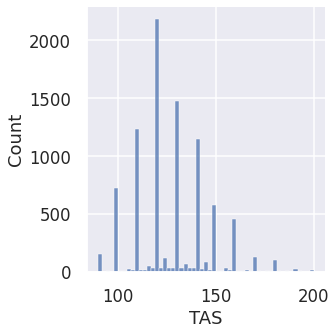

In [16]:
#Se grafican lo valores que alcanza la TAS

plt.figure(figsize=(15,10))
plt.tight_layout()
sns.displot(df_data['TAS'])

In [17]:
X = df_data['TAS'].values.reshape(-1,1)
y = df_data['TAD'].values.reshape(-1,1)
df_mod = pd.DataFrame({'X': X.flatten(), 'y': y.flatten()})
df_mod

,X,y
0,110.0,70.0
1,130.0,60.0
2,150.0,90.0
3,155.0,80.0
4,130.0,60.0
...,...,...
9038,150.0,100.0
9039,137.0,83.0
9040,110.0,60.0
9041,155.0,80.0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
df_mod = pd.DataFrame({'X_train': X_train.flatten(), 'y_train': y_train.flatten()})
df_mod.head()

,X_train,y_train
0,110.0,70.0
1,110.0,80.0
2,120.0,90.0
3,130.0,90.0
4,120.0,80.0


In [19]:
df_aux = pd.DataFrame({'X_test': X_test.flatten(), 'y_test': y_test.flatten()})
df_mod.head()

,X_train,y_train
0,110.0,70.0
1,110.0,80.0
2,120.0,90.0
3,130.0,90.0
4,120.0,80.0


In [20]:
regressor = LinearRegression() 
regressor.fit(X_train, y_train) 

LinearRegression()

In [21]:
print(regressor.intercept_)

[21.95188671]


In [22]:
print(regressor.coef_)

[[0.4483183]]


Esto significa que por cada unidad de cambio en la TAS, el cambio en la TAD es de alrededor de 0,45%.

In [23]:
y_pred = regressor.predict(X_test)

Comparación entre el valor real y el valor de predicción

In [24]:
df_mod = pd.DataFrame({'Real': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_mod

,Real,Predicted
0,80.0,71.266900
1,80.0,75.750083
2,70.0,73.508491
3,90.0,84.716449
4,95.0,95.924406
...,...,...
2708,90.0,93.682815
2709,70.0,75.750083
2710,90.0,84.716449
2711,70.0,71.266900


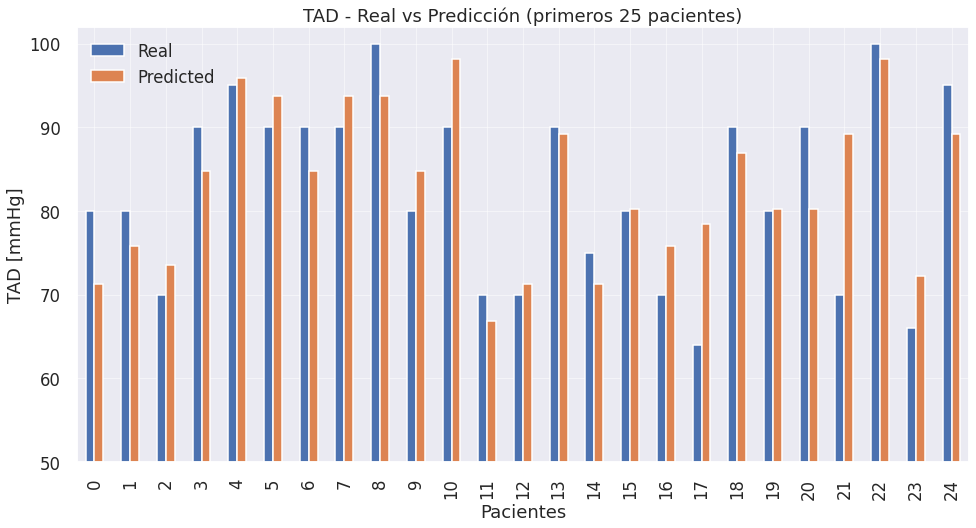

In [25]:
df_rl = df_mod.head(25)
df_rl.plot(kind='bar',figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title("TAD - Real vs Predicción (primeros 25 pacientes)")
plt.ylabel("TAD [mmHg]")
plt.xlabel("Pacientes")
plt.ylim(50, 102)
plt.show()

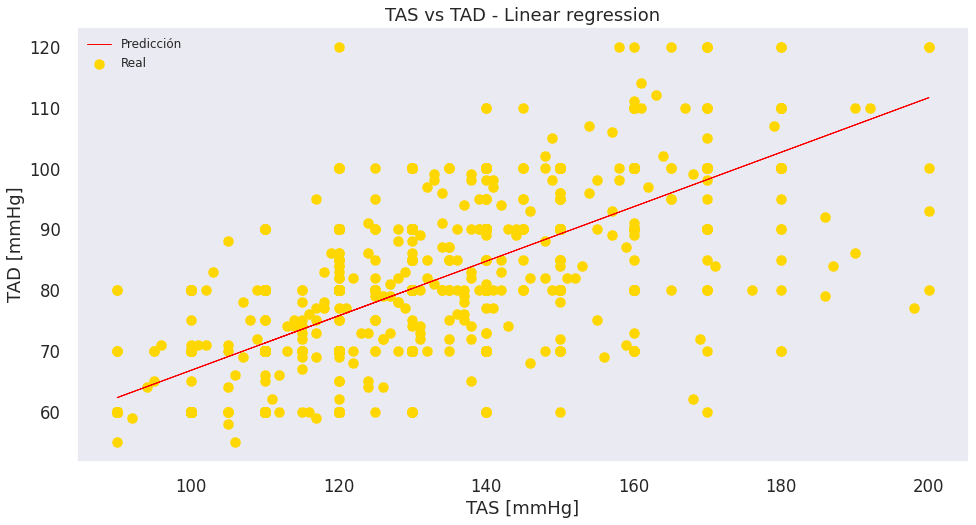

In [26]:
plt.figure(figsize=(16, 8))
plt.scatter(X_test, y_test,  color='gold', label="Real")
plt.plot(X_test, y_pred, color='red', linewidth=1, marker='x', label="Predicción")
plt.title("TAS vs TAD - Linear regression")
plt.xlabel("TAS [mmHg]")
plt.ylabel("TAD [mmHg]")
plt.legend(loc="upper left", fontsize=12)
plt.grid()
plt.show()

Medición de métricas para la evaluación del modelo de Regresión lineal simple

In [27]:
print('Error Absoluto Medio:',metrics.mean_absolute_error(y_test, y_pred)) 
print('Error Cuadratico Medio:', metrics.mean_squared_error(y_test, y_pred)) 
print('Raíz del error cuadrático medio:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Error Absoluto Medio: 6.550279872121461
Error Cuadratico Medio: 70.01930103035723
Raíz del error cuadrático medio: 8.367753643024944


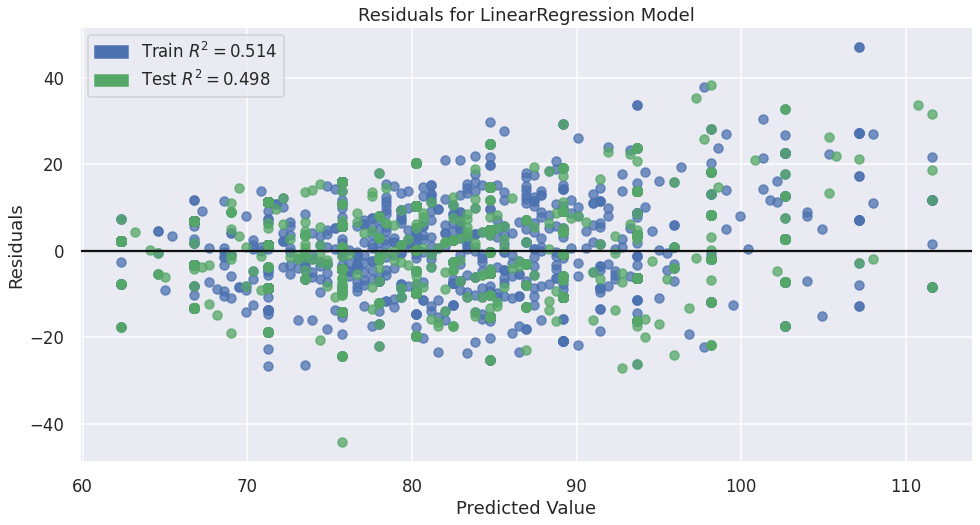

In [28]:
X_train_rl, y_train_rl, X_test_rl, y_test_rl = X_train, y_train, X_test, y_test
plt.figure(figsize=(16, 8))
visualizer = ResidualsPlot(regressor, hist=False)
visualizer.fit(X_train_rl, y_train_rl)
visualizer.score(X_test_rl, y_test_rl)
visualizer.show()

# ***Implementación del modelo de Regresión lineal múltiple***

In [29]:
X = df[['TAD', 'EDAD', 'UTMO_IMC', 'CLEARANCE', 'COLESTEROL_TOTAL']].values
y = df['TAS'].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [31]:
regressor = LinearRegression() 
regressor.fit(X_train, y_train)

LinearRegression()

In [32]:
print (regressor.intercept_)

19.937236951721246


In [33]:
list(zip(df, regressor.coef_))

[('TAS', 1.0920316640523036),
 ('TAD', 0.32204595427074517),
 ('UTMO_IMC', 0.12844057786494734),
 ('CLEARANCE', -0.002724584597234292),
 ('COLESTEROL_TOTAL', -0.002341228769762921)]

In [34]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) 
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 48.55336004597174
Mean Squared Error: 2465.500468579532
Root Mean Squared Error: 49.65380618421444


In [35]:
X_test.shape

(2713, 5)

In [36]:
(y_test - y_pred).shape

(2713, 2713)

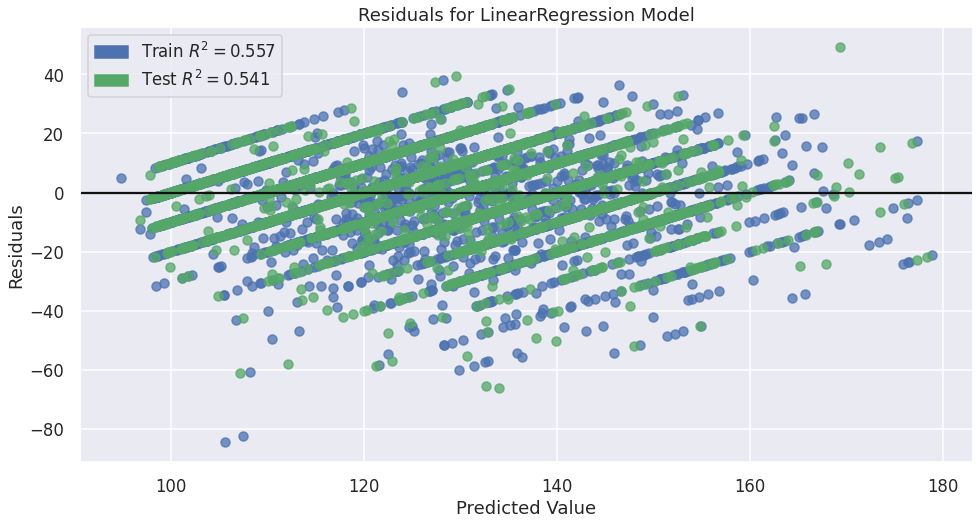

In [37]:
X_train_rm, y_train_rm, X_test_rm, y_test_rm = X_train, y_train, X_test, y_test
plt.figure(figsize=(16, 8))
visualizer = ResidualsPlot(regressor, hist=False)
visualizer.fit(X_train_rm, y_train_rm)
visualizer.score(X_test_rm, y_test_rm)
visualizer.show()

In [38]:
# print(regressor.summary())

# ***Implementación del modelo de Regresión de Ridge y Lasso con Cross validation***

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
lr = linear_model.LinearRegression()
cv = KFold(5, shuffle=True)
scores = cross_val_score(lr, X_train, y_train, cv=cv, scoring='r2')
scores, scores.mean()

(array([0.54285205, 0.54739053, 0.55307351, 0.54871291, 0.55617494]),
 0.5496407872444774)

In [40]:
model = linear_model.LassoCV().fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

{'alpha': 0.47992874621301157,
 'scores': array([0.54898238, 0.56489924, 0.54783622, 0.55159275, 0.54034484]),
 'mean_score': 0.5507310839824531,
 'zero_coefs': 1}

In [41]:
model = linear_model.LassoCV(normalize=True).fit(X, y)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

{'alpha': 0.0016219994984713914,
 'scores': array([0.56113872, 0.55824134, 0.55185452, 0.53562203, 0.55366904]),
 'mean_score': 0.5521051329339588,
 'zero_coefs': 2}

In [42]:
model = linear_model.RidgeCV(normalize=True).fit(X, y)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean())

{'alpha': 0.1,
 'scores': array([0.53447264, 0.54012258, 0.54797587, 0.54550887, 0.57161147]),
 'mean_score': 0.5479382857233748}

# ***Implementación del modelo Random Forest***

In [43]:
X = df.drop('HIPERTENSION_SI',axis=1)
y = df.HIPERTENSION_SI

In [44]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=0,stratify=y)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc= scaler.transform(X_test)

In [45]:
model_RFC = RandomForestClassifier()
params = {"n_estimators": [50,100,150],"max_depth": [8,10,15,20,25],"random_state": [0]}
clf_RFC_grid = GridSearchCV(model_RFC, param_grid=params, verbose=1)

clf_RFC_grid = clf_RFC_grid.fit(X_train_sc, y_train.values.ravel())
RFC_grid_pred= clf_RFC_grid.predict(X_test_sc)
print('Cantidad de Datos: ', len(df))
print('Mejor Combinación de Hiperparámetros en Random Forest: ',clf_RFC_grid.best_params_)
print('Métricas: ')
print(classification_report(RFC_grid_pred, y_test))
print('Accuracy: ',accuracy_score(RFC_grid_pred, y_test))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Cantidad de Datos:  9043
Mejor Combinación de Hiperparámetros en Random Forest:  {'max_depth': 10, 'n_estimators': 150, 'random_state': 0}
Métricas: 
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1705
           1       0.64      0.72      0.68      1008

    accuracy                           0.75      2713
   macro avg       0.73      0.74      0.74      2713
weighted avg       0.76      0.75      0.75      2713

Accuracy:  0.7482491706597862


<font color='magenta'>*Se quiere evaluar con los resultados de GridSearchCV y RandomForest la importancia de los aspectos considerados para la prediccion*</font>

In [46]:
model_RCF_best = RandomForestClassifier(n_estimators = 100,max_depth = 10,random_state = 0)
model_RCF_best.fit(X_train_sc,y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [47]:
y_pred = model_RCF_best.predict(X_test_sc)

In [48]:
importancias = model_RCF_best.feature_importances_
print(importancias)

[0.15400043 0.08014069 0.09624508 0.12133874 0.08323848 0.21075729
 0.01422372 0.04474629 0.05359202 0.05541332 0.06904004 0.00310714
 0.00628622 0.00787054]


In [49]:
X.columns

Index(['TAS', 'TAD', 'UTMO_IMC', 'CLEARANCE', 'COLESTEROL_TOTAL', 'EDAD',
       'SEXO_MASCULINO', 'DIABETES_DM2', 'DIABETES_NO', 'DISLIPEMIA_SI',
       'OBESIDAD_SI', 'CLASIFICACION_IMC_NORMAL', 'CLASIFICACION_IMC_OBESIDAD',
       'CLASIFICACION_IMC_SOBREPESO'],
      dtype='object')

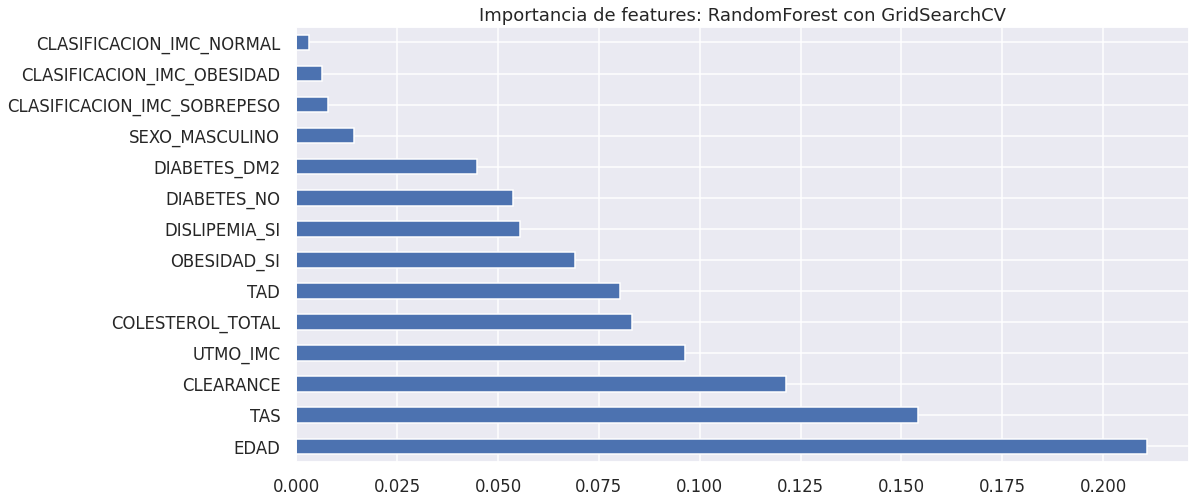

In [50]:
(pd.Series(importancias,index = X.columns).nlargest(14).plot(kind='barh', figsize=(16, 8), title='Importancia de features: RandomForest con GridSearchCV'))

<font color='pink'>*De acuerdo con los resultados de feature_importances las variables más influyentes en el modelo son: EDAD, OBESIDAD_SI,CLEARANCE, UTMO_IMC, COLESTEROL_TOTAL, TAS, TAD*</font>

In [51]:
confusion_matrix(y_test, RFC_grid_pred)

array([[1301,  279],
       [ 404,  729]])

In [52]:
print('accuracy:', accuracy_score(y_test, RFC_grid_pred))
print('recall:', recall_score(y_test, RFC_grid_pred))
print('f1_score:',f1_score(y_test, RFC_grid_pred))
print('precision:', precision_score(y_test, RFC_grid_pred))

accuracy: 0.7482491706597862
recall: 0.6434245366284201
f1_score: 0.6809901914992993
precision: 0.7232142857142857


<font color='magenta'>*Se efectua una prueba del modelo random forest reduciendo las features (segun feature_importances) para ver como resultan las metricas en este caso*</font>

In [53]:
columns = ['TAS','TAD','UTMO_IMC', 'CLEARANCE', 'COLESTEROL_TOTAL',
       'EDAD', 'OBESIDAD_SI','HIPERTENSION_SI']

In [54]:
df_new = df[columns]
df_new.shape

(9043, 8)

In [55]:
X = df_new.drop('HIPERTENSION_SI',axis=1)
y = df_new.HIPERTENSION_SI

In [56]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1, stratify=y)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [57]:
model_RFC_red = RandomForestClassifier()
params = {"n_estimators": [50,100,300], "max_depth": [8,10,15,20,25], "random_state": [0]}
clf_RFC_grid_red = GridSearchCV(model_RFC_red, param_grid=params, verbose=1)

clf_RFC_grid_red = clf_RFC_grid_red.fit(X_train_sc, y_train.values.ravel())
RFC_grid_red_pred = clf_RFC_grid_red.predict(X_test_sc)
#print('Cantidad de Datos: ',len(df))
print('Mejor Combinacion de Hiperparametros en Random Forest: ',clf_RFC_grid_red.best_params_)
print('Reporte: ')
print(classification_report(RFC_grid_red_pred, y_test))
print('Accuracy: ',accuracy_score(RFC_grid_red_pred, y_test))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mejor Combinacion de Hiperparametros en Random Forest:  {'max_depth': 10, 'n_estimators': 50, 'random_state': 0}
Reporte: 
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       784
           1       0.65      0.64      0.65       573

    accuracy                           0.70      1357
   macro avg       0.69      0.69      0.69      1357
weighted avg       0.70      0.70      0.70      1357

Accuracy:  0.7022844509948416


In [58]:
confusion_matrix(RFC_grid_red_pred,y_test)

array([[585, 199],
       [205, 368]])

In [59]:
print('accuracy:', accuracy_score(y_test, RFC_grid_red_pred))
print('recall:',recall_score(y_test, RFC_grid_red_pred))
print('f1_score:',f1_score(y_test, RFC_grid_red_pred))
print('precision:', precision_score(y_test, RFC_grid_red_pred))

accuracy: 0.7022844509948416
recall: 0.6490299823633157
f1_score: 0.6456140350877192
precision: 0.6422338568935427


In [60]:
# model_RFC_red.plot_tree(my_tree,feature_names = X.columns,filled=True,rounded=True)
# print()

<font color='pink'>*Los valores de accuracy casi no se modificaron al considerar menos aspectos. La unica diferencia significativa es que se consigue el mismo resultado pero ahora con 100 estimadores y una profundidad igual a 8*</font>